# Observing "impossible" double descent in simple linear regression

Double descent is the empirical observation that prediction test error can "descend" as more and more columns / features are added to the data.  Traditional bias-variance theory indicated it should be impossible because there was a U-curved "sweet spot" of optimal test error with only a few columns (features) because sampling variance increased with ss more columns are added.  Before this sweet spot, the model **underfits** the data; training error and test error are both high.  Beyond this sweet spot, the model **overfits** the data, meaning it is fitting noise rather than signal; as a result training error is low but test error is high.

At first, double descent was assumed to be due to some special features of deep learning or neural nets.  But in the 2020's, doube descent was observed in linear regression, too.  It was a shock.  Various researchers have started developing the theory on how, when, and where linear regression can exhibit double descent, including the Dar et al. (2023) paper cited below, which greatly inspired me.

But the math is complicated.  Code is simpler.  So this notebook illustrates the bias-variance trade-off and double descent in a linear regression model using simple python libraries.  These also help us test our intuitions by running different variations.  I also address an objection by Curth et al. (2023).

# Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

# Data set

Here I load a data set to analyze.  In an earlier [R version of this notebook](https://github.com/jeanimal/farewell_bias_variance), I used the "mtcars" data set which has data on various models in Motor Trend cars of the year.

The goal is to predict the miles per gallon (mpg) of various models based on their other characteristics.

In [2]:
import os
notebook_path = os.path.abspath("double_descent_mtcars_reg.ipynb")
print(notebook_path)
csv_path = os.path.join(os.path.dirname(notebook_path), "data/mt_cars.csv")
print(csv_path)

/Users/jeanortega/PycharmProjects/pythonProject1/double_descent_mtcars_reg.ipynb
/Users/jeanortega/PycharmProjects/pythonProject1/data/mt_cars.csv


In [3]:
df = pd.read_csv(csv_path)

In [4]:
df.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


# Split X and y

Here we put the data in a standard format for analysis.  If you load your own data set, you will need to tweak the target column and remove the non-numeric columns-- or code them, e.g. with one-hot encoding.

In [5]:
TARGET_COL = "mpg"

In [6]:
NON_NUMERIC_COLS = ["model"]

In [7]:
y = df[TARGET_COL]
X = df.drop([TARGET_COL] + NON_NUMERIC_COLS,axis=1)

# Functions

A lot of bias-variance and double descent involves:
- Getting data sets with differing numbers of rows and columns
- "Resampling" the data because it's too expensive to actually go out and collect more samples of data from the real world.
Here I give examples of how these functions work, which I have wrapped into a library.

In [8]:
random_state = 10 # For reproducibility
num_sampled_rows = 4
num_sampled_columns = 5

In [9]:
indices = np.random.choice(df.index, num_sampled_rows, replace=False)

In [10]:
# X_subset = X.sample(n=num_sampled_rows, random_state=random_state, axis=0)
X_subset = X.iloc[indices]
y_subset = y.iloc[indices]

In [11]:
X_subset = X_subset.sample(n=num_sampled_columns, random_state=random_state, axis=1)

In [12]:
X_subset

,gear,hp,qsec,vs,drat
22,3,150,17.30,0,3.15
19,4,65,19.90,1,4.22
0,4,110,16.46,0,3.90
1,4,110,17.02,0,3.90


In [13]:
y_subset

22    15.2
19    33.9
0     21.0
1     21.0
Name: mpg, dtype: float64

# Using the package

I have a little package to help sample a dataframe in a way that makes it easy to create conditions for the underfitting, interpolation, and overfitting regime of bias-variance theory.

In [14]:
# The simplest way to make this reproducible.
np.random.seed(0)

In [15]:
from double_descent_dar import sample_eval

In [16]:
random_state = None # Set for reproducibility
num_sampled_rows = 3
num_sampled_columns = 4

In [17]:
X_train, X_test, y_train, y_test = sample_eval.train_test_split_by_rows_and_cols(X, y, num_train_rows=num_sampled_rows, num_columns=num_sampled_columns, replace=False, random_state=random_state, verbose=True)

using train_size 0.09375


In [18]:
X_train

,hp,gear,wt,carb
6,245,3,3.57,4
23,245,3,3.84,4
4,175,3,3.44,2


In [19]:
y_train

6     14.3
23    13.3
4     18.7
Name: mpg, dtype: float64

What we will do is fit a linear regression on this data and then measure out of sample error.


In [20]:
# model = RandomForestRegressor()
# model = linear_model.Ridge(alpha=.5)
model = linear_model.LinearRegression(fit_intercept=True)

In [21]:
model.fit(X_train, y_train)

LinearRegression()

In [22]:
my_metric = root_mean_squared_error
# my_metric = mean_absolute_error

In [23]:
train_error = my_metric(y_train, model.predict(X_train))
train_error

np.float64(0.0)

In [24]:
test_error = my_metric(y_test, model.predict(X_test))
test_error

np.float64(3.2309801022160913)

As expected, train error (in-sample fit) is lower than test error (out of sample).

We will do this again and again and look at the average metric value for combinations of number of rows and columns.

# Bias-variance U curve

Seeing a traditional bias-variance U curve requires that the number of parameters should be a lot less than the number of rows.  Since the data set has 9 columns, we will need a lot more rows. This section will sample 15 rows (out of a total of 32) to train on.

We will sample between 2 and 8 columns (out of a total of 10 numeric columns) to see how the error metric varies by the number of parameters.

Note that the regression used here includes an intercept, so 8 columns + 1 intercept -> 9 parameters.  With 15 rows to train on, full interpolation would be reached with 15 columns.

In [25]:
X.shape

(32, 10)

In [26]:
num_train_rows = 5
num_sampled_columns = 3

In [27]:
X_train, X_test, y_train, y_test = sample_eval.train_test_split_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns, replace=False, random_state=random_state, verbose=True)
X_train

using train_size 0.15625


,disp,gear,carb
5,225.0,3,1
21,318.0,3,2
4,360.0,3,2
31,121.0,4,2
0,160.0,4,4


Here is a function to repeat this for a given number of columns.

In [28]:
model = linear_model.LinearRegression(fit_intercept=True)

In [29]:
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)

In [30]:
num_samples = 200
metric_all_samples = []
for num_sampled_columns in range(1, X.shape[1]-1):
    metric_all_samples.append((num_sampled_columns, np.array([tuple(sample_by_num_cols(num_sampled_columns).values()) for _ in range(num_samples)])))

Below we see training error (the first number in each tuple) always decreases for more columns while test error goes down but then goes back up.  We plot these on the graph.

In [31]:
print('training error, test error')
for key, values in metric_all_samples:
    the_means = np.mean(values, axis=0)
    # the_stdevs = np.std(values, axis=0)
    print(f'num_cols: {key}, mean error: {the_means}')

training error, test error
num_cols: 1, mean error: [2.95714661 5.55687761]
num_cols: 2, mean error: [1.93036880e+00 1.02681884e+13]
num_cols: 3, mean error: [ 1.03842704 12.17944466]
num_cols: 4, mean error: [ 0.22741595 18.09513797]
num_cols: 5, mean error: [ 0.04614214 13.26152085]
num_cols: 6, mean error: [9.81457287e-03 2.74177731e+11]
num_cols: 7, mean error: [1.42302495e-03 8.58218155e+00]
num_cols: 8, mean error: [3.63661931e-03 7.62698504e+00]


Now we convert the dat to a format for plotting.

In [32]:
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1], axis=0)) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
res_array = np.array(res[1])
num_cols = res[0]
train_means = res_array[:,0]
test_means= res_array[:,1]

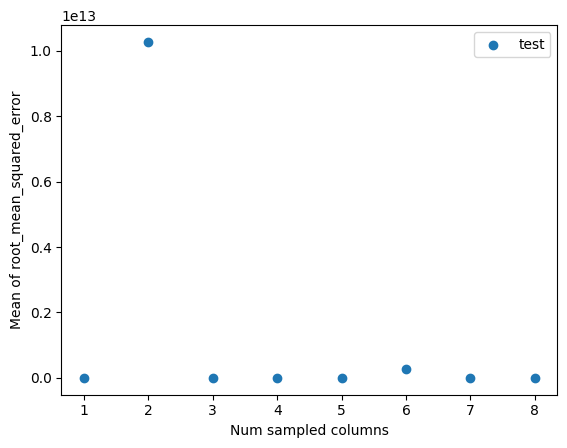

In [33]:
plt.scatter(num_cols, test_means, label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.legend()
plt.show()

The test error (in orange) display a beautiful U shape.  The linear regression's lowest average test (out-of-sample) error was achieved at 4 columns, which with the intercept means 5 parameters to fit.  This is much less than the 9 columns available in the data set.

(There is no simple theory that predicts what the optimal number of parameters will be.) 


Now let's look at a plot that includes the training error.  Notice that the training error continues to decrease as more columns are added.

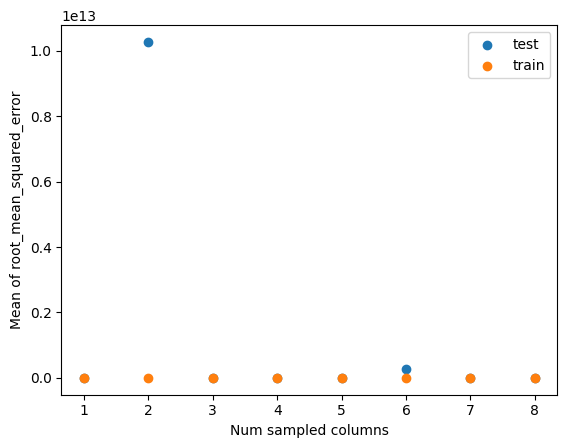

In [34]:
plt.scatter(num_cols, test_means, label='test')
plt.scatter(num_cols, train_means, label='train')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.legend()
plt.show()

## Double descent

A paper by Dar et al. (), called "Farewell to Bias Variance?" showed mathematically that double descent could be exhibited by linear regression under certain conditions. 

The paper: 
Yehuda Dar, Muthukumar, V., & Baraniuk, R. (2021). A Farewell to the Bias-Variance Tradeoff? An Overview of the Theory of Overparameterized Machine Learning. https://arxiv.org/abs/2109.02355


Here I show double descent empirically on the mtcars data set (widely used by R users).

Seeing double descent requires that the number of parameters should be a lot MORE than the number of rows. Since the data set has only 9 columns, we achieve this with a trick-- sampling fewer rows.

This section will train on 7 rows (out of a total of 32).

As before, will sample between 2 and 8 columns (out of a total of 9 columns) to see how the error metric varies by the number of parameters.  

The linear regression model will be able to fully interpolate the data at 7 columns because it is fit to 7 rows.

In [35]:
num_train_rows = 7

In [36]:
model = linear_model.LinearRegression(fit_intercept=True)

In [37]:
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)

In [38]:
num_samples = 200
metric_all_samples = []
for num_sampled_columns in range(1, X.shape[1]-1):
    metric_all_samples.append((num_sampled_columns, np.array([tuple(sample_by_num_cols(num_sampled_columns).values()) for _ in range(num_samples)])))

In [39]:
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1], axis=0)) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
res_array = np.array(res[1])
num_cols = res[0]
train_means = res_array[:,0]
test_means= res_array[:,1]

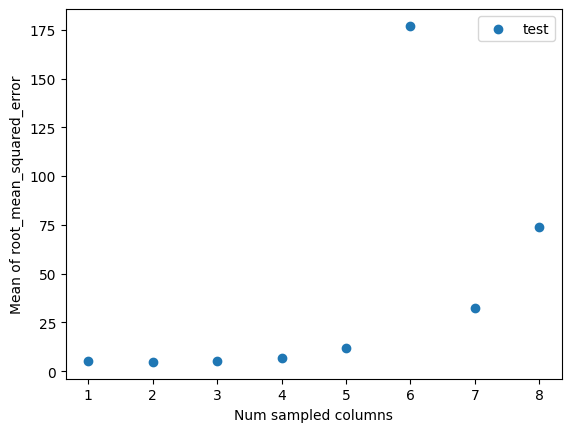

In [40]:
plt.scatter(num_cols, test_means, label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.legend()
plt.show()

As predicted, there was a spike in test (out of sample) error followed by a descent in error after the spike.  That is double descent in a linear regression. 

The key lesson: Error descends a second time after the spike, so we observe classic double descent.  Double descent was formerly thought to be a weird feature of fitting neural nets, but here we observe it with simple, traditional linear regression.

However, the transitional double descent spike was at 6 not 7 columns.  A deeper dive into training error can help us understand.  The spike should happen at the interpolation point.  Interpolation means the data could be fit perfectly, so the training error is zero.  Let's look at the mean training error for each number of columns

In [41]:
pd.DataFrame({'num sampled cols':num_cols, 'mean train error':train_means, 'mean test error':test_means})

,num sampled cols,mean train error,mean test error
0,1,3.471871,5.206709
1,2,2.500841,4.733874
2,3,1.756779,4.965807
3,4,1.386210,6.645948
4,5,0.891766,12.097241
5,6,0.147088,176.965554
6,7,0.071420,32.325548
7,8,0.013355,74.017800


I predicted that interpolation would happen at 7 sampled columns because we selected 7 rows, but we see the mean training error is not 0 at 7 columns nor even at 8 columns!

Considering why, focus on the mtcars data set (documentation: https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/mtcars).  It has some very low-variance, uninformative columns.  The column `vs` (engine type v or s) and the column `am` (automatic transmission or not) are both binary.  So if these columns were selected, perfect interpolation would not be achievable even with 7 columns for 7 rows. 

For completeness, below is a plot that includes both training and test error.

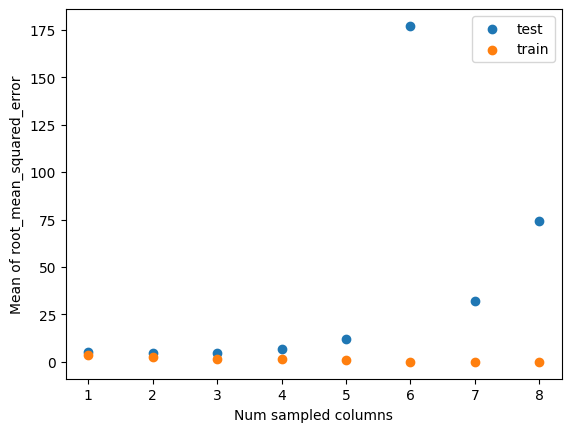

In [42]:
plt.scatter(num_cols, test_means, label='test')
plt.scatter(num_cols, train_means, label='train')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.legend()
plt.show()

# Double descent is actually two U curves in linear regression

A recent paper pointed out that different fitting methods are used on different sides of the interpolation threshold in linear regression.  When the number of rows N > number of paramters p, the best estimator involves inverting the N x p matrix.  But a matrix with more columns than rows cannot be inverted, so other parameter estimation methods are required.  The paper argues that it is this change in estimation methods that produces the two humps.  Each estimation method on its own has a U-shaped bias-variance curve, and the so-called double descent shape is just blending these two U's.

The paper:
Curth, A., Jeffares, A., & Schaar, M. van der. (2023, November 2). A U-turn on Double Descent: Rethinking Parameter Counting in Statistical Learning. Thirty-seventh Conference on Neural Information Processing Systems. https://openreview.net/forum?id=O0Lz8XZT2b


# Double descent in linear regression is real

The claim by Curth et al is correct in that many software packages switch their fitting / estimation method depending on whether the number of rows is greater or less than the number of columns.  Note that the original Dar et al paper was mathematical and so would not be subject to this criticism,  However, the sklearn implementation of LinearRegression may have different estimation methods....

So let me demonstrate double descent in a linear regression but using an estimation method that is the same on both sides of the interpolation threshold-- stochastic gradient descent (SGD).  Stochastic gradient descent is also useful to try because it is the same method used to estimate the weights in neural nets.

Notes:
* The SGDRegressor assumes input has been scaled from 0 to 1, so I wrap it inside a pipeline to handle scaling.
* By default the SGDRegressor includes regularization by default (via a penalty), so to make it comparable to the pure LinearRegression example above, I have to set the penalty to None.

In [43]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
model = make_pipeline(StandardScaler(), SGDRegressor(random_state=0, penalty=None))

Training on 15 rows, we expect a bias-variance U curve.

In [44]:
num_train_rows = 15
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)['test']

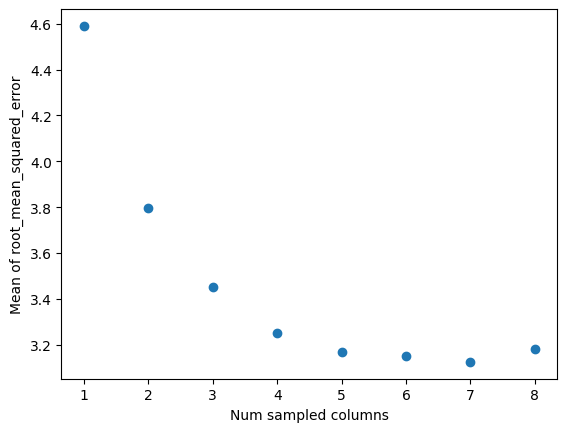

In [45]:
num_samples = 300
metric_all_samples = []
# This example won't converge because we have such a small data sst
# so we catch the warning and ignore it here.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    for num_sampled_columns in range(1, X.shape[1]-1):
        metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

Nice!  This is the "left" half of a U curve.  It minimizes test (out-of-sample) error with 7 columns.

Training on 7 rows, we hope to see double descent.

In [46]:
# Lower rows to see if we get double descent.
# The interpolation threshold is at 7 columns.
num_train_rows = 7
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)['test']

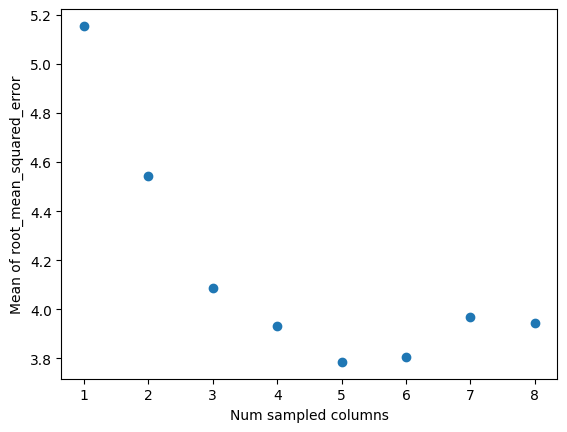

In [47]:
num_samples = 300
metric_all_samples = []
# This example won't converge because we have such a small data sst
# so we catch the warning and ignore it here.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    for num_sampled_columns in range(1, X.shape[1]-1):
        metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

The bump up at 7 columns fits the prediction.

## Conclusion

Based on the shapes above, using a consistent estimation method, I argue that **double descent is real** and not merely the overlap of two U curves from two different estimation methods.

# Appendix 1: Custom regression

Just in case the SGDRegressor has some funny stuff, I coded my own.

In [48]:
class CustomSGDRegression():

    def __init__(self, learning_rate, n_iter, batch_size, divide_by = 1, rng = None):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.divide_by = divide_by
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng
        self.weights = None
        self.bias = None

    def fit(self, X_train, y_train, verbose=False):
        # X_train and y_train must be numpy arrays.
        if isinstance(X_train, pd.DataFrame): 
            X_train = X_train.to_numpy()
        if isinstance(y_train, pd.DataFrame):
            y_train = y_train.to_numpy()
        # Initially we will keep our W and B as 0 as per the Training Data
        # w=np.zeros(shape=(1,train_data.shape[1]-1))
        num_weights = X_train.shape[1]
        w = np.zeros(shape=(1, num_weights))
        b=0
        
        cur_iter=1
        while(cur_iter <= self.n_iter): 
    
            # We will create a small training data set of size K (batch size)
            row_indices = self.rng.choice(X_train.shape[0], size=self.batch_size, replace=True)
            x = X_train[row_indices]
            y = y_train[row_indices]
            
            # We keep our initial gradients as 0
            w_gradient=np.zeros(shape=(1, num_weights))
            b_gradient=0
            
            if verbose:
                print(f'cur_iter: {cur_iter}, weights: {w}, bias: {b}')
            for i in range(self.batch_size): # Calculating gradients for point in our K sized dataset
                prediction = np.dot(w,x[i])+b
                w_gradient = w_gradient+(-2)*x[i]*(y[i]-(prediction))
                b_gradient = b_gradient+(-2)*(y[i]-(prediction))
            
            #Updating the weights(W) and Bias(b) with the above calculated Gradients
            w=w-self.learning_rate*(w_gradient/self.batch_size)
            b=b-self.learning_rate*(b_gradient/self.batch_size)
            
            # Incrementing the iteration value
            cur_iter=cur_iter+1
            
            #Dividing the learning rate by the specified value
            self.learning_rate=self.learning_rate/self.divide_by
            
        self.weights = w
        self.bias = b
        return w, b
    
    def predict(self, X):
        if self.weights is None or self.bias is None:
            raise ValueError('You must fit before predict')
        if isinstance(X, pd.DataFrame): 
            X = X.to_numpy()
        y_pred=[]
        for i in range(len(X)):
            y=np.dot(X[i], np.squeeze(self.weights)) + np.squeeze(self.bias)
            y_pred.append(y)
        return np.array(y_pred)

Note that I did tune the parameters in the constructor below to get reasonable-looking error.  sklearn uses best-in class defaults.  Also, my model is slow-- sklearn has many speed-ups, including early stopping.  Use sklearn.

In [49]:
rng = np.random.RandomState(42)
model = make_pipeline(StandardScaler(), CustomSGDRegression(learning_rate=0.001, n_iter=200, batch_size=9, rng=rng))

Training on 15 rows, we expect a bias-variance U curve.

In [50]:
y = pd.DataFrame(y)

In [51]:
num_train_rows = 15
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)['test']

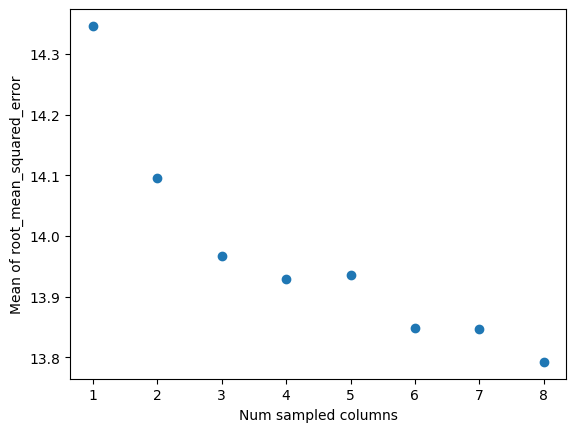

In [52]:
num_samples = 300
metric_all_samples = []
for num_sampled_columns in range(1, X.shape[1]-1):
        metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

Training on 7 rows, we hope to see double descent.  We need to lower the batch size because 9 is more than the number of rows!  I also increased the number of iterations because this data might be harder to fit.

In [53]:
model = make_pipeline(StandardScaler(), CustomSGDRegression(learning_rate=0.001, n_iter=500, batch_size=6, rng=rng))

In [54]:
num_train_rows = 7
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)['test']

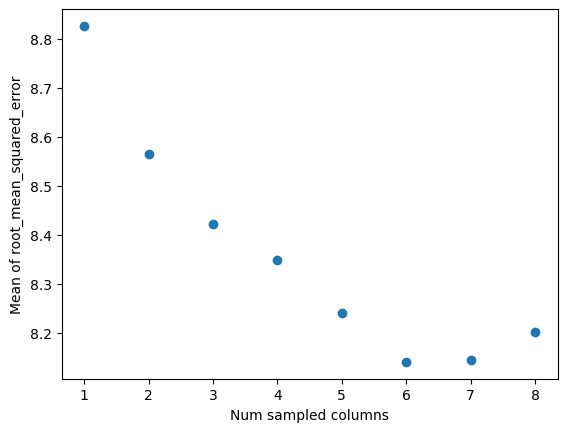

In [55]:
num_samples = 300
metric_all_samples = []
for num_sampled_columns in range(1, X.shape[1]-1):
        metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

The conclusion, again, is that double descent is real and not just an artifact of two different estimation methods.

# Appendix 2: Fun with an MLPRegressor

One cool thing about building all this with sklearn is that there are a bunch of other estimation models we can try.  I just picked one that interested me and tried to generate the same plots.

I chose to look at a simple one-layer, feed-forward neural net (MLP = multi-layer perceptron) that is fit with stochastic gradient descent.  sklearn calls it MLPRegressor.

Unlike the previous models studied here, it is not linear-- the activation function makes it non-linear.

In [62]:
y = df[TARGET_COL]
X = df.drop([TARGET_COL] + NON_NUMERIC_COLS,axis=1)

In [63]:
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# TODO: scale hidden layer neurons to number of columns.
model = make_pipeline(
    StandardScaler(), 
    MLPRegressor(hidden_layer_sizes=(4,), validation_fraction=0, solver="sgd", random_state=0))

In [64]:
# First just look for the bias-variance U curve
num_train_rows = 15

In [65]:
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)['test']

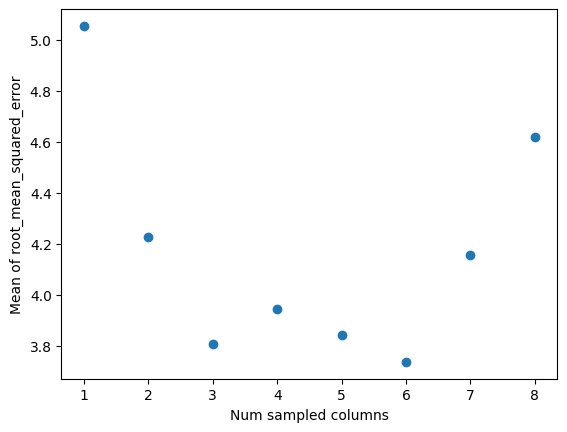

In [66]:
num_samples = 400
metric_all_samples = []
# This example won't converge because we have such a small data sst
# so we catch the warning and ignore it here.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    for num_sampled_columns in range(1, X.shape[1]-1):
        metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

This looks sort of U-shaped.  There were a lot of warnings I ignored and should look into.

In [67]:
# Lower the number of rows to look for double descent.
num_train_rows = 5

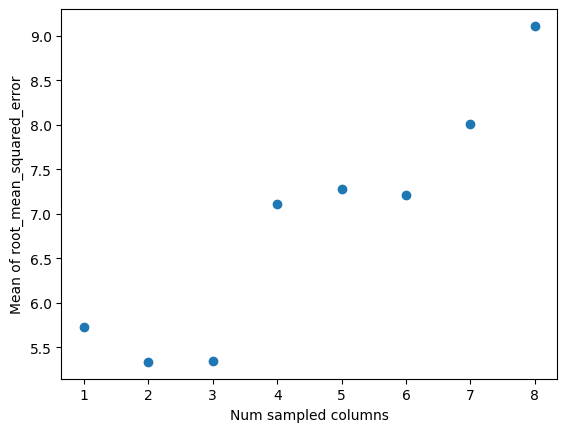

In [68]:
num_samples = 500
metric_all_samples = []
# This example won't converge because we have such a small data sst
# so we catch the warning and ignore it here.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    for num_sampled_columns in range(1, X.shape[1]-1):
        metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

I'm not sure what pattern I'm seeing.  But to do this in an apples-to-apples way with the prior regression studies, the number of hidden layer neurons should correspond to the number of sampled columns (because a weight is estimated for each neuron, and we want the number of parameters to scale, not just number of inputs).  Or maybe something else?  I'm still working on this one.